In [1]:
%matplotlib inline

# libs

# data
import pandas as pd
import numpy as np

# CNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

# plot
import matplotlib.pyplot as plt

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
path = './data/full.csv'

# load full data
D = pd.read_csv(path, index_col=0)

In [3]:
# extract inputs/targets
target_cols = list(filter(lambda x: 'c1_c0' in x, D.columns.values))
input_cols  = list(filter(lambda x: 'c1_c0' not in x, D.columns.values))
InputDF = D[input_cols]
TargetDF = D[target_cols]

# into numpy format
InputDF = InputDF.as_matrix()
TargetDF = TargetDF.as_matrix()

In [4]:
# 6 values, from 440 symbols, over 2768 days
total_days = InputDF.shape[0]
channels = 6
tickers = InputDF.shape[1]/channels
InputDF = np.reshape(InputDF, (total_days, tickers, channels))

In [13]:
# data params
test_size = 500;
window_size = 28;

X_train = np.array([InputDF[i:i + window_size] for i in range(InputDF.shape[0] - (test_size + window_size - 1) )])
X_test = np.array([InputDF[i:i + window_size] for i in range(InputDF.shape[0] - (test_size + window_size - 1), InputDF.shape[0] - window_size + 1)])

def decision(x):
    margin = 0.01
    labels = np.zeros(x.shape)
    labels[np.where(x > np.log(1 + margin))] = 1
    labels[np.where(x < np.log(1 - margin))] = -1
    return labels

y_all = TargetDF
y_train = y_all[window_size - 1 : -test_size]
y_test = y_all[-test_size:]

# data shape
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

print y_all.min()
print y_all.max()
print y_all.mean()
print y_all.std()

# print '+1 ', len(np.where(y_all == 1)[1])
# print '-1 ', len(np.where(y_all == -1)[1])
# print '=0 ', len(np.where(y_all == 0)[1])

(2241, 28, 440, 6) (2241, 440)
(500, 28, 440, 6) (500, 440)
-1.1490431423
0.70279544757
0.000293626592664
0.0242156928155


In [6]:
# KERAS STARTS HERE
batch_size = 32
epochs = 10

# dimensions
input_shape = (window_size, tickers, channels)

In [7]:
# model definition
# ADD PADDING??
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(440))
# model.add(Activation('tanh'))

print model.summary()

# model.load_weights('weights-lowhidden.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 436, 16)       2416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 434, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 217, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 76384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              78218240  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
__________

In [8]:
sgd = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)
#adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=sgd)

# tensorboard = keras.callbacks.TensorBoard(log_dir='./logs/10')
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 2241 samples, validate on 500 samples
Epoch 1/10
2241/2241 [==============================] - 5s - loss: 1.0929 - val_loss: 0.6554

In [9]:
score = model.evaluate(X_test, y_test, verbose=0)

print 'Test loss:', score
# print('Test accuracy:', score[1])

Test loss: 0.655869328022


0.102282
-0.139292
0.102282
-0.139292
[[-0.09192343  0.11298018  0.31071945 ...,  0.21795035  0.12111143
   0.0183754 ]
 [ 0.13731895 -0.46350955 -0.02077321 ...,  0.284295   -0.09526441
  -1.22489114]
 [ 0.02764866  0.08852277  0.26775081 ...,  0.47441377 -0.4303496
  -0.04345596]
 ..., 
 [-0.18446323 -0.4878827   0.28422802 ...,  0.28510779  0.04621366
   0.08698643]
 [-0.8124008  -0.59036503 -0.50481453 ..., -0.46201474 -0.26513468
  -0.71108327]
 [ 1.03125367  0.70944176  1.69128642 ...,  0.95140756  0.37649502
   0.56912994]]
[[-0.00140201 -0.01190437  0.05253343 ...,  0.01330662 -0.01549727
   0.00794888]
 [ 0.00362244 -0.01649778  0.04825616 ...,  0.02121729 -0.01006808
   0.00581311]
 [ 0.00395027 -0.0097959   0.0530626  ...,  0.02387609 -0.01036226
  -0.00120097]
 ..., 
 [ 0.00066741 -0.01133147  0.04949301 ...,  0.01149797 -0.01549689
   0.00888981]
 [ 0.00174294 -0.00962339  0.04006767 ...,  0.0147983  -0.01469027
   0.01178214]
 [-0.00181146 -0.01321072  0.04072261 ...,  0.

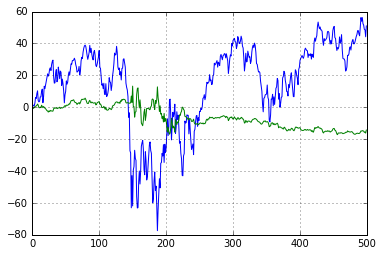

In [10]:
predictions = model.predict(X_test, batch_size=1)

def normalize(x):
    pve = np.percentile(predictions, 66)
    nve = np.percentile(predictions, 33)
    print 'pve ', pve
    print 'nve ', nve
    norms = np.zeros(x.shape)
    norms[np.where(x > pve)] = 1
    norms[np.where(x < nve)] = -1
    return norms


print predictions.max()
print predictions.min()

predictionsNormal = (predictions *  TargetDF.std()) + TargetDF.mean()


print predictions.max()
print predictions.min()

print y_test
print predictions


x_axis = np.arange(len(y_test))

fig, ax = plt.subplots()

# ax.plot(x_axis, (decision(y_test) * TargetDF[-test_size:]).sum(1).cumsum())
ax.plot(x_axis, (1 * TargetDF[-test_size:]).sum(1).cumsum())
ax.plot(x_axis, (normalize(predictions) * TargetDF[-test_size:]).sum(1).cumsum())

print normalize(predictions)
# ax.set_ylim(ymin=-500, ymax=2500)
ax.set_xlim(xmin=0, xmax=500)

# ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')

plt.grid()
plt.show()

# def labeler(x):
#     margin = 0.005
#     labels = np.zeros(x.shape)
#     labels[np.where(x > np.log(1 + margin))] = 1
#     labels[np.where(x < np.log(1 - margin))] = -1
    
#     return labels

# returns = np.apply_along_axis(labeler,
#                               axis=1,
#                               arr=predictions)

# # print predictions
# # print '---------------------------------------------------------'
# # print y_test
# # print '---------------------------------------------------------'
# print len(np.where(returns == 1)[1])
# print len(np.where(returns == -1)[1])
# print len(np.where(returns == 0)[1])

In [11]:
# DO NOT RUN THIS YET

# model.save_weights('weights-lowhidden.h5')

In [12]:
# print normalize(predictions) * TargetDF[-test_size:]
# print (normalize(predictions) * TargetDF[-test_size:]).sum(1).cumsum()